In [1]:
from artifacts_ipv6_sra_scanning.config import *
import pickle
import os
import ipaddress
import geopandas as gpd

import pycountry
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=24, split_factor=1, disable_pr_bar=False)

2025-09-26 17:29:57.939 | INFO     | artifacts_ipv6_sra_scanning.config:<module>:22 - PROJ_ROOT path is: /home/service/artifacts-ipv6-sra-scanning


In [2]:
def side_by_side(*dfs,to_pandas=True):
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 2em">'
        if to_pandas:
            html += df.to_pandas().to_html()
        else:
            html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

In [3]:
df = pl.read_csv(f'{INTERIM_DATA_DIR}/router-ips.csv')

In [4]:
df.head()

ip-addr,Geo,AS-Number,BGP-Prefix,Org
str,str,f64,str,str
"""2402:b400:4440:53ef:c822:8bff:…","""MYS""",45960.0,"""2402:b400:4440::/46""","""YTLCOMMS-AS-AP YTL COMMUNICATI…"
"""2003:e6:37ff:3ab2:3ea6:2fff:fe…","""DEU""",3320.0,"""2003::/19""","""DTAG Internet service provider…"
"""2405:8d40:4081:579:1807:c46a:e…","""PHL""",139831.0,"""2405:8d40:4080::/42""","""DTC-AS-AP DITO TELECOMMUNITY C…"
"""240e:358:9c0a:13ec:ae64:62ff:f…","""CHN""",4134.0,"""240e:358::/29""","""CHINANET-BACKBONE No.31,Jin-ro…"
"""2408:8441:5808:10fa:1807:f6b5:…","""CHN""",4837.0,"""2408:8441::/32""","""CHINA169-BACKBONE CHINA UNICOM…"


In [5]:
shapefile = f'{DATA_DIR}/shapefiles/ne_110m_admin_0_countries.shp'
gdf = gpd.read_file(shapefile)[["ADMIN","ADM0_A3","geometry"]]    
gdf.columns = ["country","country_code","geometry"]    
gdf = gdf.drop(gdf[gdf["country"]=="Antarctica"].index)
geodata = gdf.merge(df.group_by('Geo').agg(pl.len().alias('size')).to_pandas(), left_on = 'country_code', right_on = 'Geo',how="left")
geodata['size'] = geodata['size'].fillna(1)

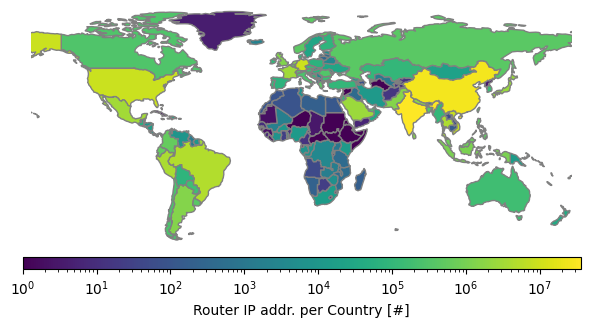

/home/service/artifacts-ipv6-sra-scanning/reports/figures/worldmap-sra-ips.png


In [8]:
worldmap_figsize = (8*0.9,5*0.9)

fig, ax = vh.fig_ax(worldmap_figsize)
ax.axis("off")

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

geodata.plot(column="size", figsize=worldmap_figsize,cmap="viridis",legend=True, 
             norm=colors.LogNorm(vmin=geodata["size"].min(), vmax=geodata["size"].max()),
             legend_kwds={"label": "Router IP addr. per Country [#]", "orientation": "horizontal","shrink":.75,'location':'bottom'},
             cax=cax,ax=ax,edgecolor='grey')

ax.set_xlim(-160,180)
ax.set_ylim(-60,85)

plt.show()

vh.save_plot(fig,'worldmap-sra-ips',autoclose=True)